# Setup Dask LOCAL Cluster

In [2]:
CLUSTER_TYPE ="local"
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=local


In [3]:
%%script bash --bg --out script_out

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching scheduler and worker"
    
    HOSTIP=`hostname -I | xargs`
    
    echo "dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787"
    
    # dask scheduler 
    dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787 &

    # dask worker
    dask-worker $HOSTIP:8786 --memory-limit 4GB --nworkers 4 --nthreads 2 &

fi

In [4]:
host_ip = !hostname -I | xargs
host_ip = host_ip[0]

from dask.distributed import Client

if CLUSTER_TYPE == "local":
    
    client = Client()

elif CLUSTER_TYPE == "docker_container":
    
    client = Client("{}:8786".format(host_ip))
    
elif CLUSTER_TYPE == "docker_cluster":
    
    # use the provided master
    client = Client("dask-scheduler:8786")
    
client

2022-07-03 18:03:43,704 - distributed.diskutils - INFO - Found stale lock file and directory '/media/alberto/Volume/Kubuntu/PoD/MAPD/B/distributed-juno/dask/dask-worker-space/worker-5jiar1da', purging
2022-07-03 18:03:43,707 - distributed.diskutils - INFO - Found stale lock file and directory '/media/alberto/Volume/Kubuntu/PoD/MAPD/B/distributed-juno/dask/dask-worker-space/worker-8_b4s8ii', purging
2022-07-03 18:03:43,709 - distributed.diskutils - INFO - Found stale lock file and directory '/media/alberto/Volume/Kubuntu/PoD/MAPD/B/distributed-juno/dask/dask-worker-space/worker-gfrcuqnr', purging
2022-07-03 18:03:43,711 - distributed.diskutils - INFO - Found stale lock file and directory '/media/alberto/Volume/Kubuntu/PoD/MAPD/B/distributed-juno/dask/dask-worker-space/worker-hrwoehyw', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38097,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.35 GiB
Comm: tcp://127.0.0.1:43057,Total threads: 2
Dashboard: http://127.0.0.1:45199/status,Memory: 3.84 GiB
Nanny: tcp://127.0.0.1:43457,


# Load data

In [5]:
import dask
import pandas as pd
import numpy as np
from tqdm import tqdm
import graphviz

In [6]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

from dask import delayed

In [6]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

In [7]:
data_folder       = "../data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "real/train/data/raw_data_train_4.npz"

In [8]:
pmt_positions     = pd.read_csv(data_folder+pmt_pos_fname)
pmt_id_conversion = pd.read_csv(data_folder+pmt_id_conv_fname)
conversion_ids = pd.read_csv(data_folder+pmt_id_conv_fname)
# train_data        = np.load(data_folder+train_data_fname, allow_pickle=True)["a"]

# very top but careful about shape
# if it fails to recognize the shape automatically
# we should probably use dask bags
data = dask.delayed(load)(data_folder+train_data_fname).compute()
#data         = da.from_delayed(delayed_data, shape=(3, 5000), dtype=list)

In [12]:
def R_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

def R_x(theta):
    return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])

def R_xz(phi,theta):
    return np.matmul(R_x(phi), R_z(theta))

@delayed    
def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

@delayed
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

In [13]:
@delayed
def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True)

In [ ]:
def process_one_event(fname):
    
    def load():
        pass
    
    def process():
        pass

    # load 1 data file
    
    # process 1 data file
    
    pass


client.map(process_one_event, fname_list)

In [114]:
Nevents = data.shape[1]

ev_dfs = []

for i in range(Nevents):
    
    nonzeros_inds = da.where(data[2, i] != 0.0)[0]
    ev_id         = dask.delayed(np.repeat)(i, len(nonzeros_inds))
    data_pmt_id   = dask.delayed(convert_pmt_ids)(data[0, i][nonzeros_inds])
    pmt_coord     = dask.delayed(find_pmt_coord)(pmt_positions, data_pmt_id)
    
    tot_charge = dask.delayed(sum)(data[1, i][nonzeros_inds])
    x_cc       = dask.delayed(sum)(pmt_coord["x"] * data[1, i][nonzeros_inds]) / tot_charge
    y_cc       = dask.delayed(sum)(pmt_coord["y"] * data[1, i][nonzeros_inds]) / tot_charge
    z_cc       = dask.delayed(sum)(pmt_coord["z"] * data[1, i][nonzeros_inds]) / tot_charge
    
    theta_cc   = dask.delayed(da.arctan2)(
        dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
    )
    phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
    
    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
    coord_new = dask.delayed(da.matmul)(
        dask.delayed(R_yz)(theta_rot, phi_rot), pmt_coord.T
    )
    
    # meta_df = pd.DataFrame(
    #     None, 
    #     columns = ['ev_id', 'pmt_id', 'x', 'y', 'z', 'x_new', 'y_new', 'z_new'],
    # )
    # meta_df = meta_df.astype({
    #         "ev_id"  : int,
    #         "pmt_id" : int,
    #         "x"      : float,
    #         "y"      : float,
    #         "z"      : float,
    #         "x_new"  : float,
    #         "y_new"  : float,
    #         "z_new"  : float,
    #         # "charge": float,
    #         # "hit_time": float
    #     })
    # ev_df = dd.from_delayed(
    #     [
    #         ev_id,
    #         data_pmt_id,
    #         pmt_coord["x"],
    #         pmt_coord["y"],
    #         pmt_coord["z"],
    #         coord_new.loc[0],
    #         coord_new.loc[1],
    #         coord_new.loc[2],
    #         # pd.Series(data[1, i][nonzeros_inds]),
    #         # pd.Series(data[2, i][nonzeros_inds])
    #     ],
    #     meta = meta_df,
    #     divisions=(0, 100)
    # )
    # # ev_df["charge"]   = pd.Series(data[1, i][nonzeros_inds])
    # # ev_df["hit_time"] = pd.Series(data[2, i][nonzeros_inds])
    
    # ev_dfs.append(ev_df)


ValueError: divisions should be a tuple of len(dfs) + 1

In [108]:
ev_dfs[0].compute()

distributed.worker - WARNING - Compute Failed
Function:  check_meta
args:      (array([0, 0, 0, ..., 0, 0, 0]), Empty DataFrame
Columns: [ev_id, pmt_id, x, y, z, x_new, y_new, z_new]
Index: [], 'from_delayed')
kwargs:    {}
Exception: "ValueError('Metadata mismatch found in `from_delayed`.\\n\\nExpected partition of type `pandas.core.frame.DataFrame` but got `numpy.ndarray`')"

distributed.worker - WARNING - Compute Failed
Function:  check_meta
args:      (array([    0,     1,     2, ..., 17606, 17608, 17611]), Empty DataFrame
Columns: [ev_id, pmt_id, x, y, z, x_new, y_new, z_new]
Index: [], 'from_delayed')
kwargs:    {}
Exception: "ValueError('Metadata mismatch found in `from_delayed`.\\n\\nExpected partition of type `pandas.core.frame.DataFrame` but got `numpy.ndarray`')"



ValueError: Metadata mismatch found in `from_delayed`.

Expected partition of type `pandas.core.frame.DataFrame` but got `numpy.ndarray`

In [78]:
a = coord_new.compute()

distributed.utils - ERROR - 'matmul'
Traceback (most recent call last):
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/distributed/utils.py", line 695, in log_errors
    yield
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 2300, in update_layout
    order = dask.order.order(
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/dask/order.py", line 116, in order
    metrics = graph_metrics(dependencies, dependents, total_dependencies)
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/dask/order.py", line 886, in graph_metrics
    val = total_dependencies[key]
KeyError: 'matmul'
bokeh.util.tornado - ERROR - Error thrown from periodic callback:
bokeh.util.tornado - ERROR - Traceback (most recent call last):
  File "/Users/niklai/miniforge3/lib/python3.9/site-packages/tornado/gen.py", line 526, in callback
    result_list.append(f.result())
  File "/Users/niklai/miniforge3/lib/python3.9/site

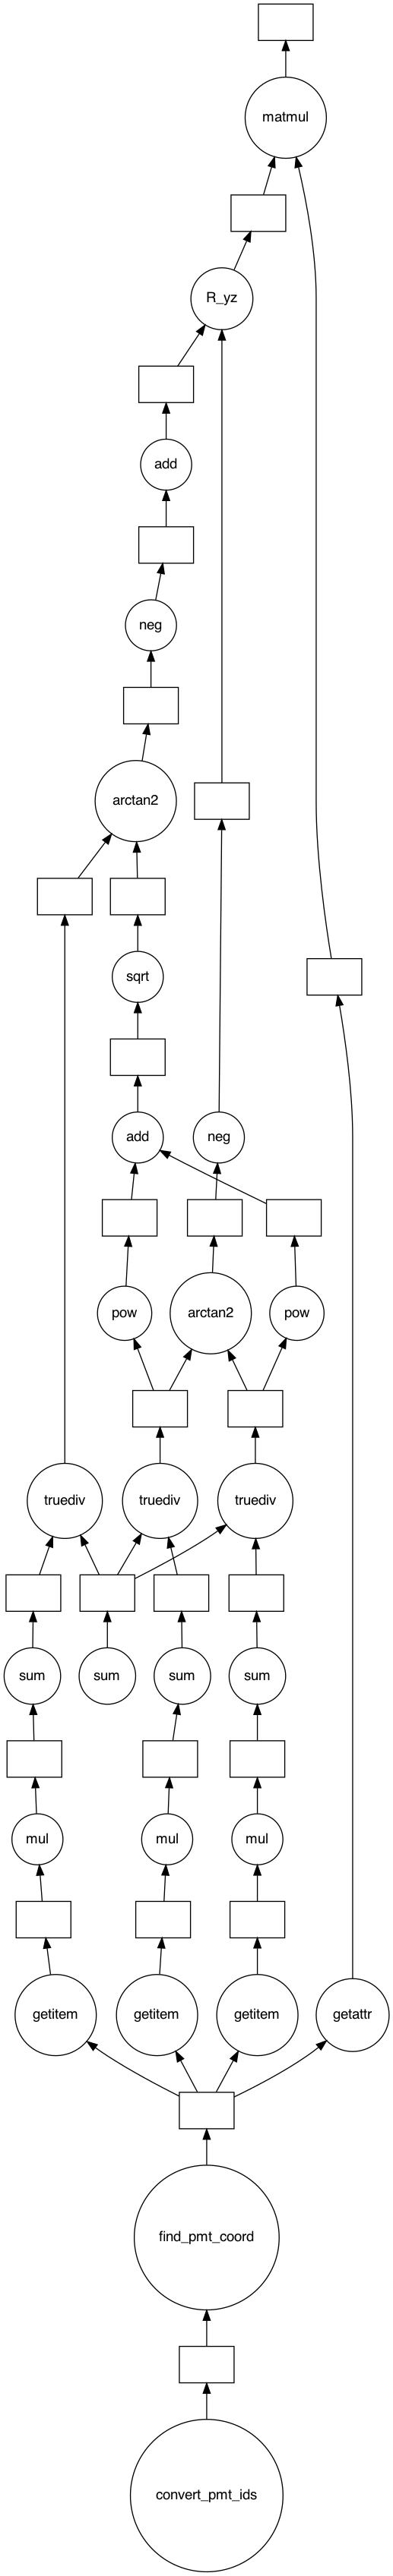

In [68]:
coord_new.visualize()

In [51]:
data_pmt_id.compute()

array([    1,     3,     5, ..., 17603, 17604, 17606])

In [47]:
arrays = [
    da.from_delayed(ev, shape=)
    for ev in pmt_coords
]

AttributeError: 'list' object has no attribute 'key'

Invece di fare il for loop su gli Nevents facciamo una funzione e usiamo map

In [103]:
def map_pmt(data):
    return list(map(convert_pmt_ids, data[0]))

def convert_id_data(data, pmt_id):
    return np.concatenate((pmt_id, data[1], data[2]), axis=1)

In [104]:
asd = dask.delayed(convert_id_data)(data, dask.delayed(map_pmt)(data))

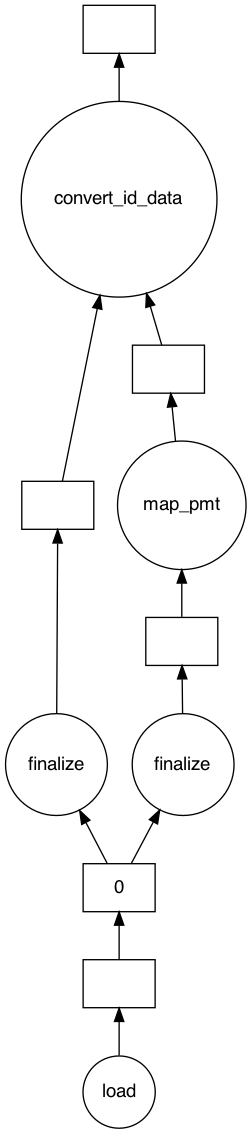

In [106]:
asd.visualize()

In [105]:
asd.compute()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
distributed.worker - WARNING - Compute Failed
Function:  convert_id_data
args:      (array([[array([268435456, 268435712, 268435968, ..., 272942592, 272943104,
               272943872])                                                ,
        array([268435456, 268435712, 268435968, ..., 272941312, 272941568,
               272942592])                                                ,
        array([268439808, 268440576, 268442368, ..., 272941312, 272942336,
               272943872])                                                ,
        ...,
        array([268435456, 268436224, 268438528, ..., 272941824, 272942592,
               272942848])                                                

AxisError: axis 1 is out of bounds for array of dimension 1

In [99]:
data.compute()[1:, :]

array([[array([1.01690963, 1.28989536, 1.45731761, ..., 0.84074667, 0.62002294,
               0.54371369])                                                    ,
        array([7.69295221, 6.3163542 , 1.64953939, ..., 0.96302451, 1.00156736,
               5.64844231])                                                    ,
        array([1.07703118, 1.44051909, 1.11252405, ..., 0.90081651, 1.31535002,
               0.65504042])                                                    ,
        ...,
        array([1.07258583, 1.1564229 , 1.02084184, ..., 0.97048609, 1.381067  ,
               0.64550814])                                                    ,
        array([1.15841609, 0.90353737, 0.98455776, ..., 4.60548049, 1.14924478,
               2.36119674])                                                    ,
        array([0.32972067, 1.56554185, 2.23426315, ..., 0.84995849, 1.00597237,
               1.72392145])                                                    ],
       [array([278.5

In [126]:
def map_pmt(data):
    def single_map(data):
        id_list = convert_pmt_ids(data[0])
        return np.vstack((id_list, data[1], data[2]))
    
    mapped_events_dlyd = []
    for i in range(data.shape[1]):
        mapped_events_dlyd.append(dask.delayed(single_map)(data[:, i]))
        
    # print(len(mapped_events_dlyd))    
    return mapped_events_dlyd

In [145]:
dlyd_list = dask.delayed(map_pmt)(data)

In [149]:
dlyd_list

Delayed('map_pmt-4a33e258-ba17-4db6-b5cb-de1f3ed762be')

In [152]:
arrr = da.from_delayed(dlyd_list, dtype=list, shape=1)


TypeError: object of type 'int' has no len()

In [143]:
da.stack(arrr, axis = 0).compute()

distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function getitem at 0x12740d820>, (<function map_pmt at 0x110904af0>, (<function finalize at 0x1273a0c10>, [(<function load at 0x12763f9d0>, '../data/raw_data_train_4.npz')])), (None, slice(None, None, None), slice(None, None, None))))
kwargs:    {}
Exception: "TypeError('list indices must be integers or slices, not tuple')"



TypeError: list indices must be integers or slices, not tuple

In [137]:
len(dlyd_list.compute())

5000

In [140]:
dlyd_list.compute()[0].compute().shape

(3, 4346)

# Distributed Mapping

In [7]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

In [8]:
data_folder       = "../data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "real/train/data/raw_data_train_4.npz"

In [9]:
pmt_positions     = pd.read_csv(data_folder+pmt_pos_fname)
pmt_id_conversion = pd.read_csv(data_folder+pmt_id_conv_fname)
conversion_ids    = pd.read_csv(data_folder+pmt_id_conv_fname)
# train_data        = np.load(data_folder+train_data_fname, allow_pickle=True)["a"]

# very top but careful about shape
# if it fails to recognize the shape automatically
# we should probably use dask bags
data = dask.delayed(load)(data_folder+train_data_fname).compute()
#data         = da.from_delayed(delayed_data, shape=(3, 5000), dtype=list)

In [10]:
def R_z(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

def R_x(theta):
    return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])

def R_xz(phi,theta):
    return np.matmul(R_x(phi), R_z(theta))

@delayed    
def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

@delayed
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

In [11]:
@delayed
def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

In [12]:
#R = 19387.6557
Nevents = 1#data.shape[1]

images_mat = da.zeros(shape=(Nevents, 124, 230, 2))
N_max = 115

error_ls = []
def rotate_single_file(fname):

    data_np = load(data_folder+fname)

    Nevents = 4 #data.shape[1]
    for i in range(Nevents):
        # find non-zero-time hits
        data = da.from_array([data_np[:,i][j] for j in range(3)])
        nonzeros_inds = da.where(data[2] != 0.0)[0]
        data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
        pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)
        
        tot_charge = dask.delayed(sum)(data[1][nonzeros_inds])
        x_cc       = dask.delayed(sum)(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
        y_cc       = dask.delayed(sum)(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
        z_cc       = dask.delayed(sum)(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge
        
        theta_cc   = dask.delayed(da.arctan2)(
            dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
        )
        phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
        
        theta_rot = -theta_cc + np.pi/2
        phi_rot   = -phi_cc
        
        # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
        coord_new = dask.delayed(da.matmul)(
            R_yz(theta_rot, phi_rot), pmt_coord.T
        )

        

        charge_hitt = da.array([data[1, i][nonzeros_inds], 
                                data[2, i][nonzeros_inds]])


        ####################
        '''
        ev_df['x_new'] = coord_new.loc[0]
        ev_df['y_new'] = coord_new.loc[1]
        ev_df['z_new'] = coord_new.loc[2]
        ev_df['R']     = np.sqrt(coord_new.loc[0]**2 + coord_new.loc[1]**2 + coord_new.loc[2]**2)
    
        
        ev_df['charge'] = pd.Series(train_data[1, i][nonzeros_inds])
        ev_df['hit_time'] = pd.Series(train_data[2, i][nonzeros_inds])
        '''
        
        '''
        MAPPING
        '''
        coord_new = coord_new.compute().persist()
        R = da.sqrt(da.sum(coord_new**2, axis=0)).mean()
        errors = 0
        z_levels, step = da.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
        image_rows = []
        for j, z in enumerate(z_levels):
            mask = (da.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
            if(not da.any(mask)): continue
            masked = coord_new[:,mask]
            
            
            Rz = (R**2 - z**2)
            if Rz < 0:
                Neff = 0
                errors = errors + 1
            else:
                Neff = N_max * da.sqrt(Rz) / R
            #ix = np.zeros(np.sum(mask), dtype=np.int32)
            ix = da.around( Neff * (da.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
            ix = ix.astype(np.int32)
            ix = ix.compute()
            if(da.any(ix >= 230)):
                ix[ix >= 230] = ix[ix >= 230] - 230
            
            image_rows.append(charge_hitt[ix, ])

            # if np.isnan(mat[ix, i+1]):
            #     mat[ix, i+1] = row.id
            # else:
            #     mat[ix, 123 if i else i] = row.id

        
        error_ls.append(errors)
    
    return image_rows
    

In [85]:
nonzeros_inds

In [43]:
result= client.gather(future)

In [44]:
get_image = client.submit(dask.compute, result[0])
get_image_result = client.gather(get_image)
get_image_result

([array([[1.49225826e+00, 3.60288129e+02],
         [1.59309770e+00, 4.61622823e+02],
         [6.17657096e-01, 6.79850537e+02],
         [1.12062462e+00, 2.99114557e+02],
         [1.17150081e+00, 3.34334823e+02],
         [1.17150081e+00, 3.34334823e+02],
         [8.13473118e-01, 3.02356700e+02],
         [8.13473118e-01, 3.02356700e+02],
         [1.44676159e+00, 8.32243943e+01],
         [6.49039096e-01, 5.30714557e+02],
         [8.13473118e-01, 3.02356700e+02],
         [1.44676159e+00, 8.32243943e+01],
         [6.49039096e-01, 5.30714557e+02],
         [6.49039096e-01, 5.30714557e+02],
         [1.44676159e+00, 8.32243943e+01],
         [6.49039096e-01, 5.30714557e+02]]),
  array([[1.14771501e+00, 3.23208129e+02],
         [1.02346542e+00, 1.16712271e+02],
         [1.21602223e+00, 3.02020843e+02],
         [1.21602223e+00, 3.02020843e+02],
         [9.17228240e-01, 3.00709700e+02],
         [1.21602223e+00, 3.02020843e+02],
         [1.41751006e+00, 1.14963056e+03],
         

In [75]:
#R = 19387.6557
Nevents = 1#data.shape[1]

images_mat = da.zeros(shape=(Nevents, 124, 230, 2))
N_max = 115

error_ls = []
def rotate_single_file(fname):

    data_np = load(data_folder+fname)
    Nevents = 10#data_np.shape[1]
    rotated = []

    for i in range(Nevents):
        # find non-zero-time hits
        data = da.from_array([data_np[:,i][j] for j in range(3)])
        nonzeros_inds = data[2] != 0.0
        data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
        pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)
        
        tot_charge = dask.delayed(sum)(data[1][nonzeros_inds])
        x_cc       = dask.delayed(sum)(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
        y_cc       = dask.delayed(sum)(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
        z_cc       = dask.delayed(sum)(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge
        
        theta_cc   = dask.delayed(da.arctan2)(
            dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
        )
        phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
        
        theta_rot = -theta_cc + np.pi/2
        phi_rot   = -phi_cc
        
        # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
        coord_new = dask.delayed(da.matmul)(
            R_yz(theta_rot, phi_rot), pmt_coord.T
        )

        R = dask.delayed(da.sqrt)(dask.delayed(da.sum)(dask.delayed(da.power)(coord_new, 2), axis=0))

        charge_hitt = da.vstack([data[1], data[2]])
        charge_hitt = charge_hitt[:,nonzeros_inds]

        rotated.append(dask.delayed(da.vstack)([coord_new, R, charge_hitt]))
        del coord_new
        del charge_hitt
        del pmt_coord
    
    return rotated

def mapping_single_event(rotated_ev):
        ####################
        # rotated_ev must be computed
        ####################
        '''
        ev_df['x_new'] = coord_new.loc[0]
        ev_df['y_new'] = coord_new.loc[1]
        ev_df['z_new'] = coord_new.loc[2]
        ev_df['R']     = np.sqrt(coord_new.loc[0]**2 + coord_new.loc[1]**2 + coord_new.loc[2]**2)
    
        
        ev_df['charge'] = pd.Series(train_data[1, i][nonzeros_inds])
        ev_df['hit_time'] = pd.Series(train_data[2, i][nonzeros_inds])
        '''
        
        '''
        MAPPING
        '''
        coord_new = rotated_ev[0:3, ]
        charge_hitt = rotated_ev[4:, ].T
        R = rotated_ev[3,].mean()
 
        z_levels, step = da.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
        z_levels = z_levels.persist()
        image_mat = da.zeros((230,124,2))

        for j, z in enumerate(z_levels):
            mask = (da.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
            if(not da.any(mask)): continue
            masked = coord_new[:,mask]
                
            Rz = (R**2 - z**2)
            if Rz < 0:
                Neff = 0
            else:
                Neff = N_max * da.sqrt(Rz) / R
            #ix = np.zeros(np.sum(mask), dtype=np.int32)
            ix = da.around( Neff * (da.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
            ix = ix.astype(np.int32)
            #ix = ix.compute()
            if(da.any(ix >= 230)):
                ix[ix >= 230] = ix[ix >= 230] - 230
            
            image_mat[ix, j,] = charge_hitt[ix, ]

            # if np.isnan(mat[ix, i+1]):
            #     mat[ix, i+1] = row.id
            # else:
            #     mat[ix, 123 if i else i] = row.id

        
    
        del rotated_ev
        return image_mat
    

2022-07-03 19:07:29,513 - distributed.worker - WARNING - Compute Failed
Key:       mapping_single_event-b48e1c2a3d424745ca8b871084621efe
Function:  mapping_single_event
args:      (dask.array<concatenate, shape=(6, 3203), dtype=float64, chunksize=(3, 3203), chunktype=numpy.ndarray>)
kwargs:    {}
Exception: "NotImplementedError('``vstack`` expects a sequence of arrays as the first argument')"

2022-07-03 19:07:30,179 - distributed.worker - WARNING - Compute Failed
Key:       mapping_single_event-1cfcd25a30a666327e03ee11e2a287ff
Function:  mapping_single_event
args:      (dask.array<concatenate, shape=(6, 8050), dtype=float64, chunksize=(3, 8050), chunktype=numpy.ndarray>)
kwargs:    {}
Exception: "NotImplementedError('``vstack`` expects a sequence of arrays as the first argument')"

2022-07-03 19:07:30,305 - distributed.worker - WARNING - Compute Failed
Key:       mapping_single_event-38246a2a7cfc1cebfdc24df177726806
Function:  mapping_single_event
args:      (dask.array<concatenate, s

In [71]:
prova1 = da.zeros(10)
prova2 = da.ones(10)

prova1[[0,1,2]] = prova2[[0,1,2]]
prova1

dask.array<setitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

In [72]:
prova = np.load(data_folder+train_data_fname, allow_pickle=True)['a']

In [19]:
pmt_positions

,PMTID,x,y,z,R,theta,phi
0,0,-930.2976,-111.8724,19365.0,19387.655713,0.0,0.0
1,1,-492.5657,-797.0872,19365.0,19387.655711,0.0,0.0
2,2,316.0782,-882.0791,19365.0,19387.655711,0.0,0.0
3,3,886.7088,-302.8474,19365.0,19387.655713,0.0,0.0
4,4,789.6295,504.4345,19365.0,19387.655710,0.0,0.0
...,...,...,...,...,...,...,...
17607,17607,774.1857,-527.8309,-19365.0,19387.655711,180.0,0.0
17608,17608,895.3717,276.1856,-19365.0,19387.655711,180.0,0.0
17609,17609,342.3245,872.2287,-19365.0,19387.655711,180.0,0.0
17610,17610,-468.5000,811.4658,-19365.0,19387.655712,180.0,0.0


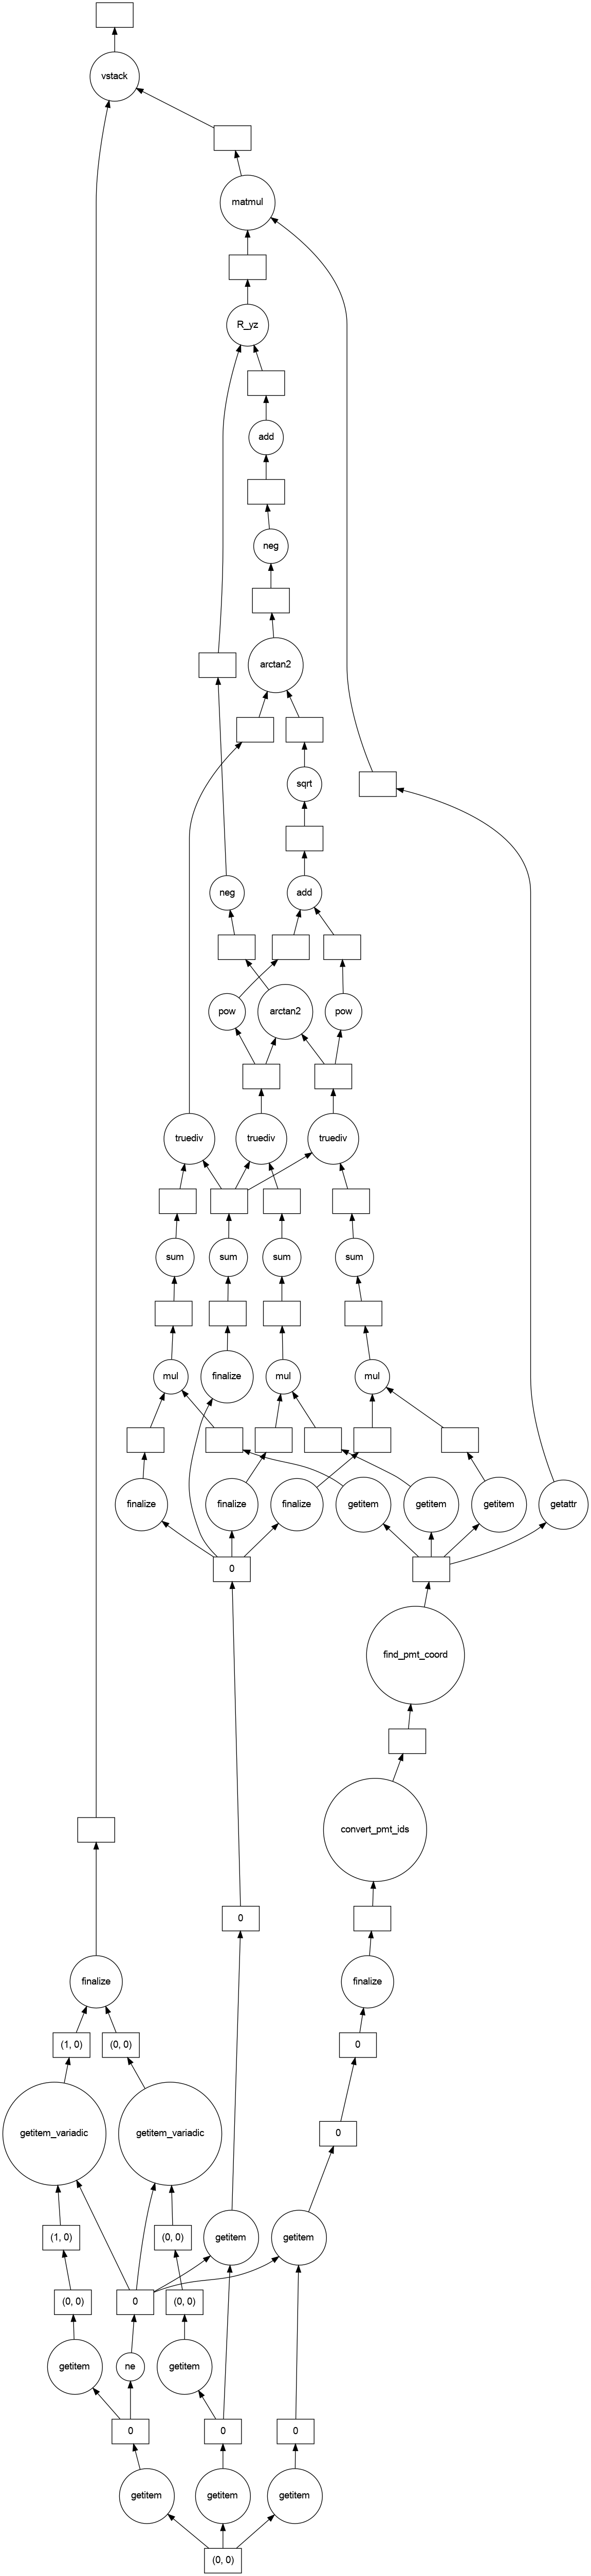

In [16]:
rotate_single_file(train_data_fname)[0].visualize()

In [14]:
future = client.map(dask.compute, rotate_single_file(train_data_fname))
result = client.gather(future)
result = [result[i][0] for i in range(len(result))]

/media/alberto/Volume/Kubuntu/anaconda3/envs/py/lib/python3.9/site-packages/distributed/worker.py:2823: UserWarning: Large object of size 1.32 MiB detected in task graph: 
  (Delayed('vstack-03ba62c2-9802-434e-b02c-f2285180eb86'),)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


In [15]:
future = client.map(dask.compute, result)
result = client.gather(future)
result = [result[i][0] for i in range(len(result))]


In [29]:
result

[dask.array<concatenate, shape=(6, 4315), dtype=float64, chunksize=(3, 4315), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 9069), dtype=float64, chunksize=(3, 9069), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 5040), dtype=float64, chunksize=(3, 5040), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 2529), dtype=float64, chunksize=(3, 2529), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 3203), dtype=float64, chunksize=(3, 3203), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 8050), dtype=float64, chunksize=(3, 8050), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 5841), dtype=float64, chunksize=(3, 5841), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 9876), dtype=float64, chunksize=(3, 9876), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 5456), dtype=float64, chunksize=(3, 5456), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(6, 5663), dtype=float64, chunksi

### Optimize mapping

In [58]:
rotated = rotate_single_file(train_data_fname)

future = client.map(dask.compute, rotated)
result = client.gather(future)
result_rot = [result[i][0].persist() for i in range(len(result))]


In [76]:
future = client.map(mapping_single_event, result_rot)
result = client.gather(future)
result

[dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(

In [77]:
future = client.map(dask.compute, result)
result = client.gather(future)
result = [result[i][0] for i in range(len(result))]

In [78]:
result[0].shape

(230, 124, 2)

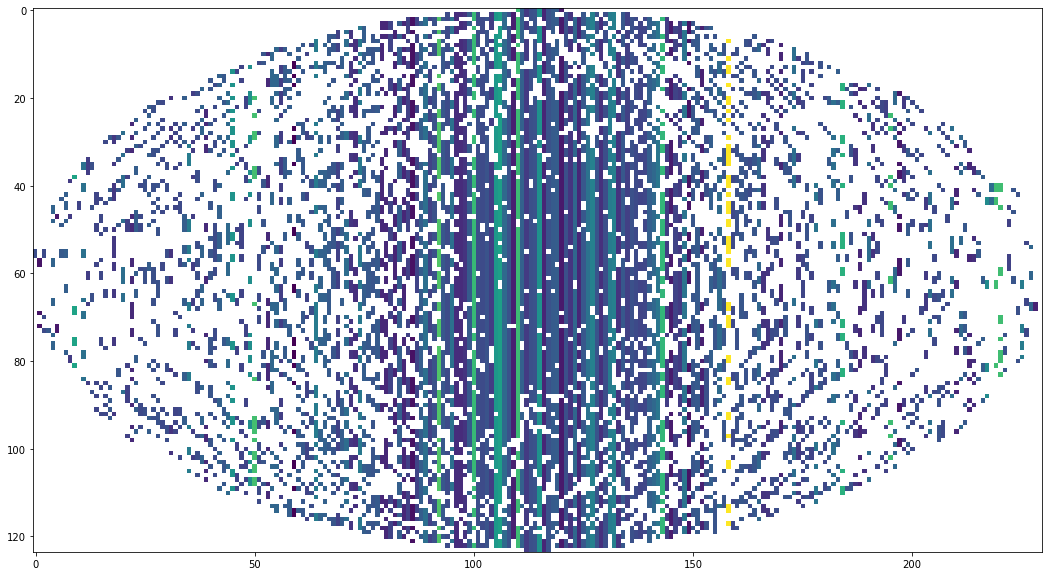

In [85]:
ev = 6

image = result[ev][:,:,0].T
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
#fig.savefig('prova.pdf')

In [91]:
rot = result_rot[6].compute()

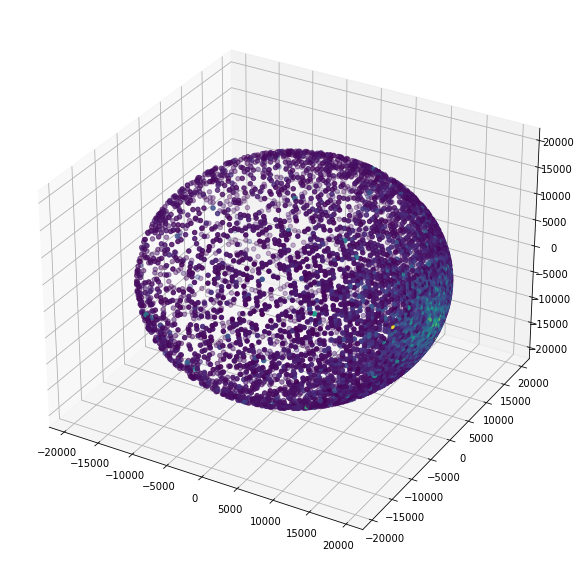

In [92]:
fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = rot[0, :],
    ys = rot[1, :],
    zs = rot[2, :],
    c  = rot[4, :])